In [1]:
import itertools # 是 Python 的內建模組，提供了一組用於處理迭代器的函數和工具。
                 # 它包含了各種用於高效處理迭代器的函數，可以幫助我們編寫更簡潔、高效的代碼。
import sys # 是 Python 的內建模組，提供了與 Python 解釋器和運行環境相關的功能。
# sys.path 是一個列表，包含了 Python 解釋器在導入模組時會搜尋的路徑。
# 當你使用 import 語句導入模組時 Python 會依次在 sys.path 中的路徑下尋找對應的模組文件。
sys.path.append("../ecg-classification/")
# sys.path.append("C:\\Users\\Chen_Lab01\\Documents\\GitHub/ecg-classification")
# from IPython.display import Video
# import cv2
from matplotlib import pyplot as plt
plt.style.use("ggplot") #  是 Matplotlib 庫中用於設置繪圖樣式的函數。它使用了一種名為 "ggplot" 的預定義樣式
import matplotlib
matplotlib.use("TkAgg")
                        #  該樣式模仿了 R 語言的 ggplot2 繪圖包的外觀。
# print(sys.path)
from ecg_tools.config import EcgConfig, Mode
from ecg_tools.data_loader import DatasetConfig, get_data_loaders
from ecg_tools.model import ECGformer
from ecg_tools.train import ECGClassifierTrainer



## Data

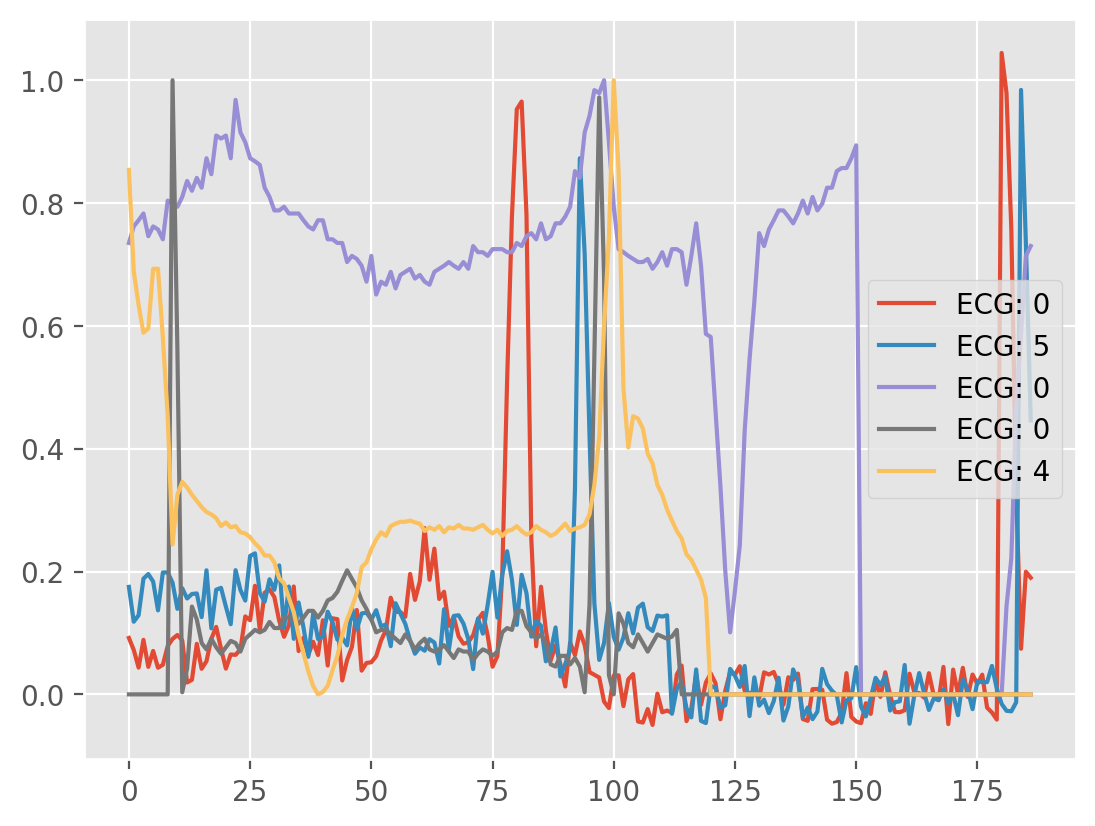

In [2]:
# 隨機抽 5 筆 ECG Data 出來觀察
NUM_EXAMPLES = 5
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)

plt.figure(1, dpi=200) # dpi 設置解析度
labels = []

for idx, data in enumerate(data_loaders[Mode.train]):
    if idx == NUM_EXAMPLES:
        break
    plt.plot(data[0][0, ...].squeeze().numpy())
    labels.append(int(data[1][0, ...].numpy()))

plt.legend([f"ECG: {label}" for label in labels])
%matplotlib inline
plt.show()

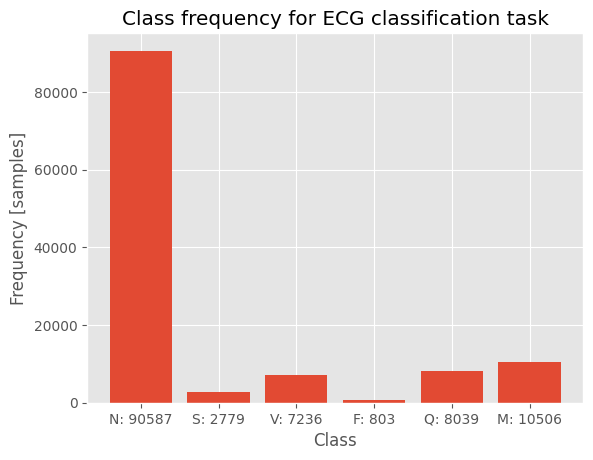

In [3]:
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)
classes = ["N", "S", "V", "F", "Q", "M"]
labels = {
    idx: 0 for idx in range(len(classes))
}

for data in itertools.chain(*list(data_loaders.values())):
    for label in data[1].numpy():
        labels[int(label)] += 1

plt.bar(range(len(classes)), list(labels.values()), tick_label=[f"{k}: {v}" for k, v in zip(classes, list(labels.values()))])
plt.title("Class frequency for ECG classification task")
plt.ylabel("Frequency [samples]")
plt.xlabel("Class")
%matplotlib inline
plt.show()

## Modeling

In [4]:
config = EcgConfig()
model = ECGformer(
    embed_size=config.model.embed_size,
    num_layers=config.model.num_layers,
    num_heads=config.model.num_heads,
    num_classes=config.model.num_classes,
    signal_length=config.model.signal_length,
    expansion=config.model.expansion,
    input_channels=config.model.input_channels
)
model
from torchinfo import summary
# input = (batch_size, signal_length, input_channels)
summary(model, input_size=(64, config.model.signal_length, 1),
       device='cpu',
       col_names=("input_size", "output_size", "num_params", "kernel_size"),
       depth=3) # depth = 3 表示只顯示到第三層
# print(model)




Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ECGformer                                          [64, 187, 1]              [64, 6]                   36,096                    --
├─LinearEmbedding: 1-1                             [64, 187, 1]              [64, 188, 192]            192                       --
│    └─Linear: 2-1                                 [64, 187, 1]              [64, 187, 192]            384                       --
│    └─LayerNorm: 2-2                              [64, 187, 192]            [64, 187, 192]            384                       --
│    └─GELU: 2-3                                   [64, 187, 192]            [64, 187, 192]            --                        --
├─ModuleList: 1-2                                  --                        --                        --                        --
│    └─TransformerEncoderLayer: 2-4                [64, 188, 192] 

### Quantization Test

In [5]:
# import torch.quantization
# model(torch.randn(1, config.model.signal_length, 1)).shape

# 使用 Eager Mode Quantization
# 將 torch.nn.Linear 的參數映射到 -127~127 之間
# quantized_model = torch.quantization.quantize_dynamic(
#     model, {torch.nn.Linear}, dtype=torch.qint8
# )

# quantized_model
# from torchinfo import summary
# summary(quantized_model, input_size=(64, config.model.signal_length, 1),
#        device='cpu',
#        col_names=("input_size", "output_size", "num_params", "kernel_size"),
#        depth=5) # depth = 3 表示只顯示到第三層
# # print(model)


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ECGformer                                          [64, 187, 1]              [64, 6]                   36,096                    --
├─LinearEmbedding: 1-1                             [64, 187, 1]              [64, 188, 192]            192                       --
│    └─Linear: 2-1                                 [64, 187, 1]              [64, 187, 192]            --                        --
│    └─LayerNorm: 2-2                              [64, 187, 192]            [64, 187, 192]            384                       --
│    └─GELU: 2-3                                   [64, 187, 192]            [64, 187, 192]            --                        --
├─ModuleList: 1-2                                  --                        --                        --                        --
│    └─TransformerEncoderLayer: 2-4                [64, 188, 192] 

### Model ParameterTest

In [6]:
# for name in quantized_model.state_dict():
#    print(name)
# 
# print(quantized_model.state_dict()['encoder.0.0.block.1.queries_projection._packed_params._packed_params'])

positional_encoding
encoder.0.0.block.0.weight
encoder.0.0.block.0.bias
encoder.0.0.block.1.queries_projection.scale
encoder.0.0.block.1.queries_projection.zero_point
encoder.0.0.block.1.queries_projection._packed_params.dtype
encoder.0.0.block.1.queries_projection._packed_params._packed_params
encoder.0.0.block.1.values_projection.scale
encoder.0.0.block.1.values_projection.zero_point
encoder.0.0.block.1.values_projection._packed_params.dtype
encoder.0.0.block.1.values_projection._packed_params._packed_params
encoder.0.0.block.1.keys_projection.scale
encoder.0.0.block.1.keys_projection.zero_point
encoder.0.0.block.1.keys_projection._packed_params.dtype
encoder.0.0.block.1.keys_projection._packed_params._packed_params
encoder.0.0.block.1.final_projection.scale
encoder.0.0.block.1.final_projection.zero_point
encoder.0.0.block.1.final_projection._packed_params.dtype
encoder.0.0.block.1.final_projection._packed_params._packed_params
encoder.0.1.block.0.weight
encoder.0.1.block.0.bias
enco

### Visualize Model

In [7]:
# quantized_model.eval()
# inputs = torch.randn(1, 187, 1)
# traced_script_module = torch.jit.trace(quantized_model, inputs)
# traced_script_module.save("traced_resnet_model.pth")

# from torchviz import make_dot
# vis_graph = make_dot(quantized_model(inputs), params=dict(quantized_model.named_parameters()), show_attrs=True, show_saved=True)
# vis_graph.view()  # 会在当前目录下保存一个“Digraph.gv.pdf”文件，并在默认浏览器中打开

# import netron
# modelData = 'traced_resnet_model.pth'
# netron.start(modelData)

## Training

TRAINING: 0, loss: 1.0325847864151. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:28<00:00, 20.21it/s]    


TRAINING Accuracy: 0.7758731842041016
[[69912     2   718    30  1801     7]
 [ 2133     2    42     2    43     1]
 [ 4135     0   743    12   892     6]
 [  635     0     4     1     1     0]
 [ 2440     0   189     3  3797     2]
 [ 7907     2   123     4   365     4]]
epoch_loss: 0.00034430969870460155


VALIDATION: 0, loss: 0.8599298000335693. Target: [0, 0, 5, 0, 0, 5, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:14<00:00, 53.35it/s] 


VALIDATION Accuracy: 0.8174583315849304
[[17485     0   385     5   242     0]
 [  513     8    33     1     1     0]
 [  632     0   738     0    78     0]
 [  160     0     1     0     1     0]
 [  190     0    30     0  1388     0]
 [ 1991     6    72     1    31     0]]


TRAINING: 1, loss: 1.0115400552749634. Target: [2, 0, 0, 0, 4, 0, 1, 0], Prediction: [2, 0, 0, 0, 4, 4, 0, 0]: 100%|██████████| 2999/2999 [02:31<00:00, 19.82it/s] 


TRAINING Accuracy: 0.8137503862380981
[[69782   195  1151   206   923   213]
 [ 1780   284    86    14    55     4]
 [ 2486    41  2711    74   445    31]
 [  539     0     8    93     1     0]
 [ 1014    26   299     6  5053    33]
 [ 7624   104   279    29   198   171]]
epoch_loss: 0.0003372924492414016


TRAINING: 2, loss: 0.9418742060661316. Target: [0, 0, 0, 0, 0, 0, 4, 0], Prediction: [0, 0, 5, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [02:33<00:00, 19.49it/s] 


TRAINING Accuracy: 0.8294952511787415
[[69397   662   825   294   600   692]
 [ 1290   756   105     6    50    16]
 [ 1862    96  3315   129   283   103]
 [  402     2    16   218     0     3]
 [  745    93   200     3  5280   110]
 [ 7212   114   254    27   159   639]]
epoch_loss: 0.00031406275627413527


VALIDATION: 2, loss: 0.5324394106864929. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 54.60it/s] 


VALIDATION Accuracy: 0.8661666512489319
[[17646    26    92   100    43   210]
 [  285   244    18     0     0     9]
 [  359     1  1023    42    16     7]
 [   48     0     7   106     1     0]
 [  128     0    11     1  1432    36]
 [ 1664     5    50     1    44   337]]


TRAINING: 3, loss: 0.7422135472297668. Target: [2, 0, 4, 0, 1, 0, 0, 0], Prediction: [0, 0, 4, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:33<00:00, 19.53it/s] 


TRAINING Accuracy: 0.8392068147659302
[[69108   683   714   322   420  1223]
 [ 1061   934   128     6    41    53]
 [ 1624    90  3588   126   222   138]
 [  352     6    15   265     1     2]
 [  605    72   162     2  5449   141]
 [ 6699   135   206    17   155  1193]]
epoch_loss: 0.00024748701141372685


TRAINING: 4, loss: 0.44618263840675354. Target: [1, 2, 0, 0, 0, 0, 5, 0], Prediction: [0, 2, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:36<00:00, 19.21it/s]


TRAINING Accuracy: 0.849032998085022
[[68868   674   659   288   347  1634]
 [ 1016  1010    96     3    27    71]
 [ 1412   117  3834   107   178   140]
 [  329    10    23   277     0     2]
 [  499    46   126     6  5604   150]
 [ 6078   107   212    18   103  1887]]
epoch_loss: 0.00014877713851508954


VALIDATION: 4, loss: 0.871433675289154. Target: [5, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 750/750 [00:14<00:00, 52.05it/s]  


VALIDATION Accuracy: 0.8802499771118164
[[17163    75   204   201   104   370]
 [  209   305    20     2     6    14]
 [  228    10  1098    81    12    19]
 [   28     0     4   129     1     0]
 [   72     2    14     2  1487    31]
 [ 1061    11    32    10    43   944]]


TRAINING: 5, loss: 0.3083733320236206. Target: [4, 0, 5, 0, 0, 0, 0, 0], Prediction: [4, 0, 4, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:36<00:00, 19.18it/s] 


TRAINING Accuracy: 0.8610891103744507
[[68717   642   631   283   322  1875]
 [  959  1099    77     2    22    64]
 [ 1197   100  4053   113   161   164]
 [  318     5    21   293     0     4]
 [  445    27   103     4  5713   139]
 [ 5249    90   190    13   101  2762]]
epoch_loss: 0.00010282538580314124


TRAINING: 6, loss: 0.28180116415023804. Target: [0, 0, 4, 0, 5, 0, 0, 0], Prediction: [0, 0, 4, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:35<00:00, 19.24it/s]


TRAINING Accuracy: 0.869175136089325
[[68756   679   590   270   266  1909]
 [  872  1180    76     3    20    72]
 [ 1128    79  4183   116   136   146]
 [  298     1    31   307     1     3]
 [  383    29   110     2  5740   167]
 [ 4790    94   162     9   103  3247]]
epoch_loss: 9.396504306443415e-05


VALIDATION: 6, loss: 0.2671549618244171. Target: [0, 4, 4, 2, 0, 0, 0, 0], Prediction: [0, 4, 4, 2, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:14<00:00, 53.47it/s] 


VALIDATION Accuracy: 0.9151250123977661
[[17560   103    66    11    27   350]
 [  208   319    17     0     1    11]
 [  183    13  1191    22     2    37]
 [   56     0    12    94     0     0]
 [   84     2    18     0  1459    45]
 [  722     8    17     0    14  1340]]


TRAINING: 7, loss: 1.0068038702011108. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 1, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:35<00:00, 19.25it/s] 


TRAINING Accuracy: 0.8747394680976868
[[68727   580   559   287   280  2037]
 [  843  1218    77     3    11    71]
 [  983    95  4301   100   137   172]
 [  279     7    26   322     0     7]
 [  411    17    99     2  5770   132]
 [ 4414    90   169    16   107  3609]]
epoch_loss: 0.000335713194465192


TRAINING: 8, loss: 0.6335954666137695. Target: [0, 0, 0, 0, 1, 0, 4, 0], Prediction: [0, 0, 0, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [02:36<00:00, 19.13it/s] 


TRAINING Accuracy: 0.8800225257873535
[[68810   633   556   277   228  1966]
 [  800  1264    77     3    14    65]
 [  974   109  4346   107   101   151]
 [  250     9    24   347     2     9]
 [  347    17    95     2  5825   145]
 [ 4213    74   147    23    86  3862]]
epoch_loss: 0.00021126891184187048


VALIDATION: 8, loss: 0.3754695951938629. Target: [5, 0, 5, 0, 0, 0, 4, 0], Prediction: [0, 0, 5, 0, 0, 0, 4, 0]: 100%|██████████| 750/750 [00:14<00:00, 52.72it/s]  


VALIDATION Accuracy: 0.9260416626930237
[[17668    73   125    39    30   182]
 [  198   328    20     1     3     6]
 [  107     9  1253    43    13    23]
 [   37     0    11   113     1     0]
 [   70     2    13     0  1501    22]
 [  672     5    29     7    26  1362]]


TRAINING: 9, loss: 0.8344898223876953. Target: [0, 0, 0, 0, 0, 2, 5, 1], Prediction: [0, 0, 0, 5, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [02:36<00:00, 19.16it/s] 


TRAINING Accuracy: 0.884628176689148
[[68777   637   536   268   232  2020]
 [  801  1283    65     0    10    64]
 [  886    88  4450   100   110   154]
 [  237     4    38   351     1    10]
 [  331    27    83     2  5855   133]
 [ 3868    91   155    22    89  4180]]
epoch_loss: 0.0002782560261379444


TRAINING: 10, loss: 0.35979610681533813. Target: [0, 0, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 5, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [02:36<00:00, 19.20it/s]


TRAINING Accuracy: 0.8879209756851196
[[68697   634   518   289   224  2108]
 [  773  1311    61     2    15    61]
 [  800    87  4542   113    87   159]
 [  233     7    32   363     0     6]
 [  305    19    89     1  5890   127]
 [ 3666    80   147    18    85  4409]]
epoch_loss: 0.00011997202628053956


VALIDATION: 10, loss: 0.6409972310066223. Target: [0, 4, 0, 0, 4, 0, 0, 0], Prediction: [0, 0, 0, 0, 4, 0, 2, 0]: 100%|██████████| 750/750 [00:14<00:00, 53.31it/s]  


VALIDATION Accuracy: 0.9114166498184204
[[16818   103   286   137    38   735]
 [  160   335    21     2     3    35]
 [   59     6  1313    38     2    30]
 [   20     0    23   117     1     1]
 [   39     3     9     1  1534    22]
 [  277     4    39     8    16  1757]]


TRAINING: 11, loss: 0.23513078689575195. Target: [0, 4, 1, 0, 0, 5, 0, 4], Prediction: [0, 4, 1, 0, 0, 5, 0, 4]: 100%|██████████| 2999/2999 [02:34<00:00, 19.46it/s]


TRAINING Accuracy: 0.891859769821167
[[68709   635   501   316   207  2102]
 [  736  1336    62     4    12    73]
 [  735    76  4608   122    90   157]
 [  224     4    37   366     0    10]
 [  291    12    64     1  5935   128]
 [ 3448    85   146    18    72  4636]]
epoch_loss: 7.840306331969054e-05


TRAINING: 12, loss: 0.4523991048336029. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:31<00:00, 19.78it/s] 


TRAINING Accuracy: 0.8961424231529236
[[68819   617   491   280   212  2051]
 [  750  1348    53     4     9    59]
 [  704    83  4608   118    87   188]
 [  207     6    38   380     1     9]
 [  275    13    57     3  5955   128]
 [ 3173    88   148    19    86  4891]]
epoch_loss: 0.00015084998493951414


VALIDATION: 12, loss: 0.18397991359233856. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 55.94it/s] 


VALIDATION Accuracy: 0.9304999709129333
[[17352   223   181    38    82   241]
 [  155   374    19     1     3     4]
 [   73    14  1277    41    18    25]
 [   26     1    10   124     1     0]
 [   24     2     3     0  1570     9]
 [  377    22    30     1    36  1635]]


TRAINING: 13, loss: 0.32515737414360046. Target: [0, 5, 0, 0, 0, 5, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:31<00:00, 19.80it/s]


TRAINING Accuracy: 0.8981744050979614
[[68739   594   495   292   238  2112]
 [  721  1383    59     1    10    49]
 [  667    73  4686    98    80   184]
 [  224     3    40   363     1    10]
 [  285    17    64     0  5957   108]
 [ 3030    82   133    17    75  5068]]
epoch_loss: 0.00010842193202520855


TRAINING: 14, loss: 0.407451868057251. Target: [0, 5, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [02:31<00:00, 19.79it/s]   


TRAINING Accuracy: 0.9021340608596802
[[68862   599   472   268   225  2044]
 [  686  1401    48     2    15    71]
 [  673    78  4708    94    75   160]
 [  198     4    39   387     0    13]
 [  279    10    64     2  5972   104]
 [ 2844    78   144    21    72  5246]]
epoch_loss: 0.000135862576878043


VALIDATION: 14, loss: 0.06300882995128632. Target: [0, 0, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 5]: 100%|██████████| 750/750 [00:13<00:00, 55.85it/s] 


VALIDATION Accuracy: 0.9393749833106995
[[17859    44    23     5    39   147]
 [  219   331     4     0     1     1]
 [  174    20  1178    31    14    31]
 [   69     0     3    86     2     2]
 [   36     1     4     0  1555    12]
 [  542     1     2     0    20  1536]]


TRAINING: 15, loss: 0.17169003188610077. Target: [0, 0, 2, 4, 0, 4, 4, 0], Prediction: [0, 0, 2, 4, 0, 4, 4, 0]: 100%|██████████| 2999/2999 [02:31<00:00, 19.77it/s] 


TRAINING Accuracy: 0.9052600860595703
[[68913   597   460   288   208  2004]
 [  685  1416    51     2    10    59]
 [  641    54  4746   107    61   179]
 [  210     4    36   377     1    13]
 [  270    10    66     1  5984   100]
 [ 2704    59   123    18    61  5440]]
epoch_loss: 5.724909365992023e-05


TRAINING: 16, loss: 0.19416368007659912. Target: [0, 0, 5, 0, 4, 5, 5, 4], Prediction: [0, 0, 5, 0, 4, 0, 5, 4]: 100%|██████████| 2999/2999 [02:31<00:00, 19.79it/s] 


TRAINING Accuracy: 0.9065625667572021
[[68879   605   500   264   199  2023]
 [  697  1407    42     0     8    69]
 [  566    70  4779   126    76   171]
 [  176     3    40   409     1    12]
 [  260    11    54     2  6022    82]
 [ 2627    63   131    18    61  5505]]
epoch_loss: 6.474280762807573e-05


VALIDATION: 16, loss: 0.32066234946250916. Target: [0, 4, 0, 0, 0, 0, 0, 0], Prediction: [0, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 55.98it/s] 


VALIDATION Accuracy: 0.9402083158493042
[[17528   266    76    58    37   152]
 [  155   388     8     0     1     4]
 [   96    11  1275    40     9    17]
 [   24     3     8   125     1     1]
 [   38     1     8     0  1552     9]
 [  343    22    17     1    21  1697]]


TRAINING: 17, loss: 0.4621821641921997. Target: [0, 5, 0, 0, 0, 5, 0, 0], Prediction: [0, 5, 0, 0, 0, 5, 0, 1]: 100%|██████████| 2999/2999 [02:31<00:00, 19.80it/s]  


TRAINING Accuracy: 0.9100533127784729
[[68932   609   445   248   223  2013]
 [  662  1445    50     2    10    54]
 [  570    68  4818   101    66   165]
 [  178     3    45   403     0    12]
 [  238    11    54     1  6036    91]
 [ 2460    64   104    20    55  5702]]
epoch_loss: 0.00015411209209476482


TRAINING: 18, loss: 0.27540817856788635. Target: [0, 0, 0, 0, 4, 5, 0, 0], Prediction: [0, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [02:31<00:00, 19.74it/s] 


TRAINING Accuracy: 0.9122311472892761
[[69006   580   450   258   204  1972]
 [  665  1435    50     1    11    61]
 [  550    61  4862   100    62   153]
 [  182     3    43   401     0    12]
 [  243     5    56     1  6037    89]
 [ 2323    65   131    18    64  5804]]
epoch_loss: 9.183333730172937e-05


VALIDATION: 18, loss: 0.058094292879104614. Target: [0, 0, 0, 0, 0, 0, 0, 2], Prediction: [0, 0, 0, 0, 0, 0, 0, 2]: 100%|██████████| 750/750 [00:13<00:00, 55.66it/s]


VALIDATION Accuracy: 0.9508333206176758
[[17669   113    81    16    23   215]
 [  158   384     7     0     1     6]
 [   84    19  1281    32     6    26]
 [   34     0    11   115     1     1]
 [   37     1     5     0  1555    10]
 [  257     6    12     0    10  1816]]


TRAINING: 19, loss: 0.09841100126504898. Target: [0, 4, 0, 0, 0, 0, 0, 0], Prediction: [0, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:32<00:00, 19.64it/s] 


TRAINING Accuracy: 0.9135128259658813
[[69007   610   436   258   185  1974]
 [  635  1473    34     1    13    67]
 [  535    71  4863    94    63   162]
 [  178     2    41   408     1    11]
 [  230     4    59     0  6053    85]
 [ 2258    77   124    17    65  5864]]
epoch_loss: 3.281460529011303e-05


TRAINING: 20, loss: 0.5269163846969604. Target: [0, 0, 0, 0, 0, 5, 0, 0], Prediction: [0, 0, 0, 0, 0, 5, 1, 1]: 100%|██████████| 2999/2999 [02:33<00:00, 19.51it/s]  


TRAINING Accuracy: 0.9149820804595947
[[68999   611   442   269   185  1964]
 [  643  1476    37     1     8    58]
 [  545    66  4889    94    54   140]
 [  172     2    45   408     0    14]
 [  237     9    49     0  6054    82]
 [ 2189    51   117    15    50  5983]]
epoch_loss: 0.00017569736068588212


VALIDATION: 20, loss: 0.06556180864572525. Target: [0, 0, 0, 4, 0, 0, 0, 0], Prediction: [0, 0, 0, 4, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 55.18it/s] 


VALIDATION Accuracy: 0.9509999752044678
[[17601   132    55    17    46   266]
 [  152   385     7     0     1    11]
 [   96    10  1273    32    11    26]
 [   30     2    10   119     0     1]
 [   25     1     4     0  1570     8]
 [  190     4     8     0    23  1876]]


TRAINING: 21, loss: 0.06404978036880493. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:31<00:00, 19.78it/s] 


TRAINING Accuracy: 0.9177954792976379
[[69146   563   449   249   193  1870]
 [  630  1470    46     2    10    65]
 [  503    52  4934    93    57   149]
 [  157     5    40   426     0    13]
 [  241     6    42     1  6076    65]
 [ 2115    63   120    25    55  6027]]
epoch_loss: 2.1357045804869933e-05


TRAINING: 22, loss: 0.4936731457710266. Target: [5, 0, 0, 0, 0, 5, 0, 0], Prediction: [0, 5, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [02:32<00:00, 19.66it/s]  


TRAINING Accuracy: 0.9184832572937012
[[69073   646   441   232   204  1874]
 [  607  1523    38     1     7    47]
 [  493    64  4918   102    61   150]
 [  158     4    35   433     1    10]
 [  226     8    56     0  6058    83]
 [ 2031    58   102    13    61  6140]]
epoch_loss: 0.00016461258611904855


VALIDATION: 22, loss: 0.10011488944292068. Target: [2, 5, 0, 0, 0, 0, 0, 0], Prediction: [2, 5, 0, 0, 1, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 55.44it/s] 


VALIDATION Accuracy: 0.9469999670982361
[[17489   131   110    99    13   275]
 [  135   384    22     1     1    13]
 [   66     4  1308    55     0    15]
 [   18     0     6   135     1     2]
 [   49     1    11     0  1533    14]
 [  188     8    16     2     8  1879]]


TRAINING: 23, loss: 0.21131113171577454. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [02:31<00:00, 19.77it/s] 


TRAINING Accuracy: 0.9208069443702698
[[69224   548   405   240   196  1857]
 [  602  1516    37     0     8    60]
 [  500    35  4967    95    45   146]
 [  155     1    45   427     1    12]
 [  218    10    39     1  6088    75]
 [ 2039    47   106    14    53  6146]]
epoch_loss: 7.046053074884113e-05


TRAINING: 24, loss: 0.23660820722579956. Target: [0, 5, 2, 0, 0, 0, 0, 0], Prediction: [0, 5, 2, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:31<00:00, 19.86it/s] 


TRAINING Accuracy: 0.9208902716636658
[[69193   559   416   231   184  1887]
 [  652  1473    35     2     8    53]
 [  486    51  4950    91    51   159]
 [  157     0    47   425     1    11]
 [  221     2    44     2  6091    71]
 [ 1931    55   112    14    49  6244]]
epoch_loss: 7.889570097559172e-05


VALIDATION: 24, loss: 0.20530648529529572. Target: [0, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 750/750 [00:13<00:00, 55.95it/s] 


VALIDATION Accuracy: 0.949833333492279
[[17513   280    58    20    19   227]
 [  121   421     5     0     1     8]
 [   56    24  1296    33     5    34]
 [   33     2     7   118     0     2]
 [   28     2     7     0  1554    17]
 [  176    19     4     0     8  1894]]


TRAINING: 25, loss: 0.2776903212070465. Target: [1, 0, 5, 2, 0, 1, 0, 0], Prediction: [1, 0, 0, 2, 0, 1, 0, 0]: 100%|██████████| 2999/2999 [02:31<00:00, 19.82it/s]  


TRAINING Accuracy: 0.9236516356468201
[[69237   608   414   231   177  1803]
 [  615  1522    34     1     9    42]
 [  465    49  5004    84    52   134]
 [  151     1    35   437     0    17]
 [  200     8    43     1  6115    64]
 [ 1839    62   110    20    48  6326]]
epoch_loss: 9.259430517073908e-05


TRAINING: 26, loss: 0.10059409588575363. Target: [5, 0, 0, 0, 0, 0, 0, 2], Prediction: [5, 0, 0, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [02:31<00:00, 19.86it/s] 


TRAINING Accuracy: 0.9241622090339661
[[69281   563   427   222   182  1795]
 [  574  1542    41     1     9    56]
 [  466    45  4996    91    50   140]
 [  164     3    47   421     0     6]
 [  197     5    50     0  6105    74]
 [ 1844    56    99    21    40  6345]]
epoch_loss: 3.3542546143965865e-05


VALIDATION: 26, loss: 0.07182175666093826. Target: [0, 0, 0, 0, 0, 2, 0, 0], Prediction: [0, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 56.01it/s] 


VALIDATION Accuracy: 0.9554166793823242
[[17609   216    58    29    15   190]
 [  116   430     5     0     1     4]
 [   70    11  1328    13     4    22]
 [   23     0    26   111     1     1]
 [   38     3     6     0  1551    10]
 [  174    10    10     0     6  1901]]


TRAINING: 27, loss: 0.5833438634872437. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:31<00:00, 19.83it/s]  


TRAINING Accuracy: 0.9256835579872131
[[69269   596   388   249   190  1778]
 [  595  1542    36     1     8    41]
 [  443    53  5023    85    50   134]
 [  145     2    40   439     0    15]
 [  202     7    40     1  6121    60]
 [ 1755    43    99    20    46  6442]]
epoch_loss: 0.00019451279209311225


TRAINING: 28, loss: 0.4881350100040436. Target: [0, 0, 0, 1, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:31<00:00, 19.84it/s]  


TRAINING Accuracy: 0.9263191819190979
[[69355   554   396   250   180  1735]
 [  589  1527    31     4    11    61]
 [  457    43  5005    91    40   152]
 [  160     1    42   429     1     8]
 [  226     6    46     0  6085    68]
 [ 1693    53   101    21    41  6496]]
epoch_loss: 0.00016276592530978446


VALIDATION: 28, loss: 0.4456237852573395. Target: [0, 0, 0, 5, 5, 0, 0, 5], Prediction: [0, 0, 0, 0, 5, 0, 0, 5]: 100%|██████████| 750/750 [00:13<00:00, 56.23it/s]  


VALIDATION Accuracy: 0.9437916278839111
[[17266   263   132    59    91   306]
 [  117   419    12     1     1     6]
 [   54     9  1333    18    14    20]
 [   22     0    17   121     1     1]
 [   19     1     3     0  1580     5]
 [  122    13     9     0    25  1932]]


TRAINING: 29, loss: 0.15663644671440125. Target: [0, 0, 4, 0, 0, 4, 0, 0], Prediction: [0, 0, 4, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [02:31<00:00, 19.82it/s] 


TRAINING Accuracy: 0.9281010031700134
[[69393   550   386   254   152  1735]
 [  576  1561    30     0     9    47]
 [  448    42  5026    76    48   148]
 [  143     0    44   441     0    13]
 [  186     8    38     3  6142    54]
 [ 1694    45    93    18    50  6505]]
epoch_loss: 5.2229558757719656e-05


TRAINING: 30, loss: 0.18576131761074066. Target: [0, 5, 4, 0, 0, 0, 0, 5], Prediction: [0, 5, 4, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [02:31<00:00, 19.80it/s] 


TRAINING Accuracy: 0.9287679195404053
[[69442   568   363   209   181  1707]
 [  592  1527    38     3     4    59]
 [  428    48  5042    93    48   129]
 [  149     1    48   432     0    11]
 [  180     5    42     0  6139    65]
 [ 1657    54    83    18    43  6550]]
epoch_loss: 6.194108623232432e-05


VALIDATION: 30, loss: 0.1334814727306366. Target: [4, 0, 0, 0, 0, 0, 0, 0], Prediction: [4, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 55.69it/s]  


VALIDATION Accuracy: 0.9605416655540466
[[17922    28    26    11    16   114]
 [  197   351     4     0     1     3]
 [  133     6  1259    31     4    15]
 [   40     0     7   110     0     5]
 [   42     0     3     0  1554     9]
 [  235     0     1     0     8  1857]]


TRAINING: 31, loss: 0.533658504486084. Target: [3, 0, 0, 5, 0, 0, 0, 5], Prediction: [0, 1, 0, 5, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [02:31<00:00, 19.83it/s]   


TRAINING Accuracy: 0.9290388226509094
[[69399   602   384   229   170  1686]
 [  570  1558    34     0     5    56]
 [  445    46  5017    84    51   145]
 [  151     3    41   435     0    11]
 [  172     1    37     0  6149    72]
 [ 1595    54    98    16    42  6600]]
epoch_loss: 0.0001779454833231357


TRAINING: 32, loss: 0.08360222727060318. Target: [0, 0, 0, 0, 0, 0, 0, 4], Prediction: [0, 0, 0, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [02:30<00:00, 19.92it/s] 


TRAINING Accuracy: 0.9317063689231873
[[69549   552   394   214   164  1597]
 [  571  1567    29     3     5    48]
 [  398    47  5077    81    46   139]
 [  138     1    44   441     2    15]
 [  216     8    33     0  6115    59]
 [ 1526    50    97    17    50  6665]]
epoch_loss: 2.787670132397572e-05


VALIDATION: 32, loss: 0.047218143939971924. Target: [5, 5, 0, 0, 0, 0, 0, 5], Prediction: [5, 5, 0, 0, 0, 0, 0, 5]: 100%|██████████| 750/750 [00:13<00:00, 56.39it/s]


VALIDATION Accuracy: 0.9644583463668823
[[17870    43    20    18    13   153]
 [  164   373     5     1     1    12]
 [  104     6  1280    29     2    27]
 [   32     1     9   119     0     1]
 [   34     0     6     0  1556    12]
 [  141     3     2     1     5  1949]]


TRAINING: 33, loss: 0.07545013725757599. Target: [0, 4, 0, 0, 4, 0, 0, 0], Prediction: [0, 4, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [02:30<00:00, 19.97it/s] 


TRAINING Accuracy: 0.9325712323188782
[[69554   568   362   244   161  1581]
 [  582  1562    27     2    10    40]
 [  413    48  5094    81    35   117]
 [  127     3    52   448     1    10]
 [  202     3    31     2  6141    52]
 [ 1513    46    87    15    46  6698]]
epoch_loss: 2.5158431896490826e-05


TRAINING: 34, loss: 0.6654300689697266. Target: [0, 1, 0, 0, 5, 0, 0, 0], Prediction: [0, 1, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:30<00:00, 19.92it/s]  


TRAINING Accuracy: 0.9332902431488037
[[69593   556   364   239   159  1559]
 [  559  1579    33     2     6    44]
 [  420    48  5058    85    48   129]
 [  145     2    45   440     0     9]
 [  184     4    46     0  6142    55]
 [ 1446    45   106    10    44  6754]]
epoch_loss: 0.00022188398431801485


VALIDATION: 34, loss: 0.2002168744802475. Target: [2, 4, 0, 0, 0, 4, 0, 0], Prediction: [5, 4, 0, 0, 0, 4, 0, 0]: 100%|██████████| 750/750 [00:13<00:00, 56.44it/s]  


VALIDATION Accuracy: 0.9459999799728394
[[17349   460   119    45    34   110]
 [  105   433    15     0     0     3]
 [   41     7  1364    19     4    13]
 [   20     1    17   123     1     0]
 [   29     4    10     0  1558     7]
 [  168    30    15     1    10  1877]]


TRAINING: 35, loss: 0.26656150817871094. Target: [0, 5, 0, 0, 0, 2, 5, 0], Prediction: [1, 0, 0, 0, 0, 2, 5, 0]: 100%|██████████| 2999/2999 [02:30<00:00, 19.92it/s] 


TRAINING Accuracy: 0.9337382912635803
[[69626   555   363   239   168  1519]
 [  540  1587    36     0     7    53]
 [  410    39  5095    90    42   112]
 [  149     2    42   440     0     8]
 [  195     2    46     0  6141    47]
 [ 1491    45    88    22    39  6720]]
epoch_loss: 8.888346388086393e-05


TRAINING: 36, loss: 0.269671767950058. Target: [0, 0, 1, 0, 0, 0, 0, 2], Prediction: [0, 0, 1, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [02:40<00:00, 18.74it/s]   


TRAINING Accuracy: 0.9339362978935242
[[69599   542   348   237   161  1583]
 [  559  1578    32     1     6    47]
 [  373    54  5120    81    47   113]
 [  159     2    38   432     1     9]
 [  184     7    34     2  6146    58]
 [ 1437    59    91    18    47  6753]]
epoch_loss: 8.992056283763187e-05


VALIDATION: 36, loss: 0.023429902270436287. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:14<00:00, 50.89it/s]


VALIDATION Accuracy: 0.9642916321754456
[[17814    44    56    14    10   179]
 [  167   369     9     1     0    10]
 [   68     6  1335    19     0    20]
 [   26     0    15   119     0     2]
 [   41     0     7     0  1551     9]
 [  132     0     7     0     7  1955]]


TRAINING: 37, loss: 0.3696099519729614. Target: [0, 5, 2, 0, 0, 0, 0, 0], Prediction: [0, 5, 2, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [02:42<00:00, 18.48it/s]  


TRAINING Accuracy: 0.9355514049530029
[[69647   580   336   228   174  1505]
 [  531  1595    30     2     5    60]
 [  409    47  5107    77    34   114]
 [  144     1    43   442     0    11]
 [  173     5    35     0  6171    47]
 [ 1388    43    92    19    42  6821]]
epoch_loss: 0.000123244398790584


TRAINING: 38, loss: 0.48424506187438965. Target: [0, 0, 0, 0, 0, 1, 0, 0], Prediction: [0, 0, 0, 0, 0, 1, 0, 0]: 100%|██████████| 2999/2999 [02:46<00:00, 18.04it/s] 


TRAINING Accuracy: 0.9356139302253723
[[69674   563   359   221   171  1482]
 [  528  1594    40     1     6    54]
 [  397    47  5080    90    50   124]
 [  130     2    44   450     0    15]
 [  181     4    37     0  6157    52]
 [ 1389    49    72    20    41  6834]]
epoch_loss: 0.0001614688435726541


VALIDATION: 38, loss: 0.054877787828445435. Target: [0, 0, 0, 0, 0, 0, 2, 0], Prediction: [0, 0, 0, 0, 0, 0, 2, 0]: 100%|██████████| 750/750 [00:15<00:00, 49.34it/s]


VALIDATION Accuracy: 0.9593333005905151
[[17722   114    96    15    32   138]
 [  146   390    11     0     1     8]
 [   48    10  1354    18     5    13]
 [   29     0    17   112     1     3]
 [   29     0     6     0  1568     5]
 [  193     3    14     0    13  1878]]


TRAINING: 39, loss: 0.5508596301078796. Target: [5, 1, 0, 0, 5, 1, 5, 0], Prediction: [5, 0, 0, 0, 5, 1, 5, 2]: 100%|██████████| 2999/2999 [02:46<00:00, 18.02it/s]  


TRAINING Accuracy: 0.9367497563362122
[[69711   563   336   212   162  1486]
 [  515  1617    28     1     8    54]
 [  375    36  5139    86    37   115]
 [  131     3    41   458     0     8]
 [  167    12    33     1  6170    48]
 [ 1412    56    77    13    44  6803]]
epoch_loss: 0.0001836811037372056


TRAINING: 40, loss: 0.05119916424155235. Target: [0, 0, 0, 0, 2, 0, 0, 0], Prediction: [0, 0, 0, 0, 2, 0, 0, 0]: 100%|██████████| 2999/2999 [02:46<00:00, 17.99it/s] 


TRAINING Accuracy: 0.9375104308128357
[[69691   581   382   198   150  1468]
 [  540  1599    28     1     5    50]
 [  386    34  5137    72    36   123]
 [  131     2    37   461     0    10]
 [  174    10    21     1  6170    55]
 [ 1296    46    86    17    47  6913]]
epoch_loss: 1.707207877344193e-05


VALIDATION: 40, loss: 0.16474084556102753. Target: [4, 0, 0, 0, 0, 0, 0, 3], Prediction: [2, 0, 0, 0, 0, 0, 0, 3]: 100%|██████████| 750/750 [00:14<00:00, 51.70it/s]  


VALIDATION Accuracy: 0.9620833396911621
[[17863    37    32     9    15   161]
 [  172   365     6     1     2    10]
 [   79     6  1328     7     3    25]
 [   40     0    27    94     0     1]
 [   35     0     6     0  1557    10]
 [  200     0     9     0     9  1883]]


TRAINING: 41, loss: 0.37956738471984863. Target: [0, 3, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:46<00:00, 18.03it/s] 


TRAINING Accuracy: 0.9382293820381165
[[69716   575   329   217   163  1470]
 [  518  1625    27     2     4    47]
 [  372    38  5158    72    46   102]
 [  126     2    42   463     0     8]
 [  170     5    41     1  6173    41]
 [ 1340    34    68    15    43  6905]]
epoch_loss: 0.0001265646497898795


TRAINING: 42, loss: 0.5985875725746155. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 2, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:47<00:00, 17.94it/s]  


TRAINING Accuracy: 0.9384899139404297
[[69722   562   338   228   154  1466]
 [  510  1615    31     4     6    57]
 [  373    50  5141    88    36   100]
 [  123     1    40   464     0    13]
 [  170     3    41     0  6165    52]
 [ 1244    54    94    19    36  6958]]
epoch_loss: 0.00019959572276579375


VALIDATION: 42, loss: 0.03995390981435776. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:15<00:00, 48.62it/s] 


VALIDATION Accuracy: 0.9664166569709778
[[17894    22    45    11    24   121]
 [  177   366     6     1     1     5]
 [   77     6  1325    19     5    16]
 [   36     0    17   107     0     2]
 [   24     0     6     0  1569     9]
 [  148     0    10     0    10  1933]]


TRAINING: 43, loss: 0.38349685072898865. Target: [0, 0, 0, 0, 0, 0, 0, 4], Prediction: [0, 0, 0, 0, 0, 0, 5, 2]: 100%|██████████| 2999/2999 [02:47<00:00, 17.96it/s] 


TRAINING Accuracy: 0.9383857250213623
[[69670   571   337   217   149  1526]
 [  512  1638    21     0     8    44]
 [  372    34  5170    80    40    92]
 [  126     1    43   460     0    11]
 [  168     3    33     2  6183    42]
 [ 1273    52    82    19    45  6934]]
epoch_loss: 0.00012787490854584483


TRAINING: 44, loss: 0.8670642971992493. Target: [5, 1, 4, 0, 0, 0, 0, 0], Prediction: [0, 1, 4, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:47<00:00, 17.95it/s]  


TRAINING Accuracy: 0.939500629901886
[[69840   538   358   207   137  1390]
 [  531  1603    35     0     2    52]
 [  374    35  5152    82    39   106]
 [  131     0    41   453     1    15]
 [  168     6    31     0  6173    53]
 [ 1291    40    82    11    40  6941]]
epoch_loss: 0.0002891178050014169


VALIDATION: 44, loss: 0.1617213934659958. Target: [4, 1, 0, 0, 0, 0, 2, 0], Prediction: [4, 1, 0, 0, 0, 0, 2, 0]: 100%|██████████| 750/750 [00:15<00:00, 49.01it/s]   


VALIDATION Accuracy: 0.9661666750907898
[[17839    63    33    15    13   154]
 [  148   388     5     1     1    13]
 [   65     9  1313    27     4    30]
 [   24     1    11   124     0     2]
 [   27     0     2     0  1568    11]
 [  137     1     2     0     5  1956]]


TRAINING: 45, loss: 0.33517295122146606. Target: [0, 0, 0, 0, 4, 0, 0, 0], Prediction: [0, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [02:49<00:00, 17.70it/s] 


TRAINING Accuracy: 0.9407823085784912
[[69835   569   346   202   135  1383]
 [  526  1621    23     1     7    45]
 [  374    26  5178    83    34    93]
 [  126     2    42   460     1    10]
 [  164     5    36     1  6181    44]
 [ 1222    54    69    15    35  7010]]
epoch_loss: 0.00011176157093079895


TRAINING: 46, loss: 0.12181822955608368. Target: [0, 0, 0, 0, 4, 0, 0, 0], Prediction: [0, 0, 1, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [02:47<00:00, 17.93it/s] 


TRAINING Accuracy: 0.9410219788551331
[[69827   582   327   203   159  1372]
 [  519  1615    38     2     8    41]
 [  370    45  5167    75    41    90]
 [  116     2    45   470     0     8]
 [  170     5    35     0  6179    42]
 [ 1191    48    73    17    26  7050]]
epoch_loss: 4.0619616390824834e-05


VALIDATION: 46, loss: 0.013710850849747658. Target: [0, 0, 0, 4, 0, 0, 4, 5], Prediction: [0, 0, 0, 4, 0, 0, 4, 5]: 100%|██████████| 750/750 [00:15<00:00, 49.46it/s] 


VALIDATION Accuracy: 0.9645416736602783
[[17731   123    28    24    51   160]
 [  127   415     4     1     1     8]
 [   57     9  1330    26     9    17]
 [   23     2    14   122     0     1]
 [   12     1     4     0  1584     7]
 [  111     3     3     0    17  1967]]


TRAINING: 47, loss: 0.10983983427286148. Target: [0, 0, 0, 5, 0, 0, 0, 0], Prediction: [0, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:44<00:00, 18.22it/s] 


TRAINING Accuracy: 0.9415847063064575
[[69861   533   319   215   150  1392]
 [  520  1629    32     2     5    35]
 [  351    44  5183    71    32   107]
 [  118     2    47   465     0     9]
 [  163     5    30     1  6192    40]
 [ 1199    47    83    11    33  7032]]
epoch_loss: 3.662548658648266e-05


TRAINING: 48, loss: 0.05566560849547386. Target: [0, 2, 0, 2, 0, 0, 5, 0], Prediction: [0, 2, 0, 2, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [02:45<00:00, 18.17it/s] 


TRAINING Accuracy: 0.9417096972465515
[[69851   565   323   217   139  1375]
 [  514  1626    29     1     5    48]
 [  352    42  5179    82    36    97]
 [  123     3    38   467     0    10]
 [  154     7    39     1  6189    41]
 [ 1165    50    76    14    38  7062]]
epoch_loss: 1.856138996181189e-05


VALIDATION: 48, loss: 0.07569309324026108. Target: [5, 0, 0, 4, 0, 0, 0, 0], Prediction: [5, 0, 0, 4, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:15<00:00, 49.86it/s] 


VALIDATION Accuracy: 0.9631249904632568
[[17635   124    28    26    14   290]
 [  123   415     5     1     1    11]
 [   56     8  1338    14     8    24]
 [   19     0    15   124     1     3]
 [   24     3     2     0  1568    11]
 [   53     3     2     0     8  2035]]


TRAINING: 49, loss: 0.12648868560791016. Target: [4, 0, 0, 0, 0, 0, 0, 0], Prediction: [4, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:44<00:00, 18.23it/s] 


TRAINING Accuracy: 0.9426579475402832
[[69891   515   335   219   145  1365]
 [  499  1650    25     1     7    41]
 [  334    38  5201    81    36    98]
 [  127     1    43   460     0    10]
 [  155     9    41     0  6188    38]
 [ 1167    45    71    16    31  7075]]
epoch_loss: 4.217695418736584e-05


TRAINING: 50, loss: 0.037909138947725296. Target: [0, 4, 0, 0, 0, 4, 0, 0], Prediction: [0, 4, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [02:47<00:00, 17.95it/s]


TRAINING Accuracy: 0.9436374306678772
[[69952   518   327   202   144  1327]
 [  475  1678    23     0     6    41]
 [  334    31  5209    82    34    98]
 [  112     1    39   474     0    15]
 [  145    11    30     1  6211    33]
 [ 1204    41    69    20    36  7035]]
epoch_loss: 1.2640593180301866e-05


VALIDATION: 50, loss: 0.12196455895900726. Target: [5, 0, 5, 0, 0, 0, 0, 0], Prediction: [5, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:14<00:00, 50.14it/s] 


VALIDATION Accuracy: 0.9667916297912598
[[17780   141    33    17    14   132]
 [  118   422     4     1     1    10]
 [   59    10  1329    28     3    19]
 [   19     0    11   127     1     4]
 [   22     5     3     0  1569     9]
 [  101     8     6     0    10  1976]]


TRAINING: 51, loss: 0.3872146010398865. Target: [0, 0, 1, 2, 0, 0, 4, 0], Prediction: [0, 0, 1, 2, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [02:49<00:00, 17.70it/s]  


TRAINING Accuracy: 0.9440542459487915
[[69964   533   327   188   153  1305]
 [  489  1640    34     1     6    53]
 [  326    38  5213    78    38    95]
 [  129     1    51   457     0     3]
 [  166     4    26     0  6188    47]
 [ 1096    52    71    13    36  7137]]
epoch_loss: 0.0001291145718705857


TRAINING: 52, loss: 0.09353591501712799. Target: [0, 2, 0, 0, 0, 0, 0, 0], Prediction: [0, 2, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:46<00:00, 17.98it/s] 


TRAINING Accuracy: 0.94474196434021
[[69947   555   314   209   144  1301]
 [  466  1680    28     1     6    42]
 [  327    41  5215    73    27   105]
 [  109     0    49   472     0    11]
 [  156     6    32     1  6201    35]
 [ 1100    37    71    13    34  7150]]
epoch_loss: 3.118903468393731e-05


VALIDATION: 52, loss: 0.05782937631011009. Target: [0, 0, 5, 4, 5, 0, 0, 0], Prediction: [0, 0, 5, 4, 5, 0, 0, 0]: 100%|██████████| 750/750 [00:15<00:00, 49.35it/s] 


VALIDATION Accuracy: 0.9571666717529297
[[17538   369    58    19    19   114]
 [   88   457     8     0     1     2]
 [   43    20  1337    26     2    20]
 [   22     3    18   119     0     0]
 [   26     4     7     0  1565     6]
 [  112    20     4     0     9  1956]]


TRAINING: 53, loss: 0.11984936147928238. Target: [0, 0, 5, 0, 0, 0, 2, 0], Prediction: [0, 0, 5, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [02:46<00:00, 17.96it/s] 


TRAINING Accuracy: 0.9442939162254333
[[69909   580   333   200   130  1318]
 [  472  1671    30     1     5    44]
 [  317    30  5233    75    31   102]
 [  112     2    38   479     0    10]
 [  162     8    25     0  6187    49]
 [ 1097    50    68     9    38  7143]]
epoch_loss: 3.996310819582607e-05


TRAINING: 54, loss: 0.412982314825058. Target: [0, 0, 0, 0, 1, 0, 0, 0], Prediction: [0, 0, 0, 0, 1, 0, 0, 0]: 100%|██████████| 2999/2999 [02:43<00:00, 18.35it/s]   


TRAINING Accuracy: 0.9456693530082703
[[70049   513   302   179   141  1286]
 [  493  1650    26     1     5    48]
 [  322    44  5212    82    34    94]
 [  110     2    34   484     2     9]
 [  173     5    36     0  6173    44]
 [ 1060    44    72     8    35  7186]]
epoch_loss: 0.00013770667383296366


VALIDATION: 54, loss: 0.09267953038215637. Target: [0, 0, 1, 0, 0, 0, 2, 0], Prediction: [0, 0, 1, 1, 0, 0, 5, 0]: 100%|██████████| 750/750 [00:14<00:00, 50.24it/s]  


VALIDATION Accuracy: 0.9651249647140503
[[17791   149    46     9    52    70]
 [  117   425    10     1     2     1]
 [   55     4  1355    15     6    13]
 [   28     0    20   112     0     2]
 [   15     1     6     0  1582     4]
 [  162     8     7     0    26  1898]]


TRAINING: 55, loss: 0.10289960354566574. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:44<00:00, 18.18it/s] 


TRAINING Accuracy: 0.9459715485572815
[[70010   542   332   202   140  1244]
 [  484  1667    30     2     4    36]
 [  312    34  5245    70    29    98]
 [  124     1    42   468     1     5]
 [  142     6    29     0  6216    38]
 [ 1082    43    63     9    31  7177]]
epoch_loss: 3.4311304950205317e-05


TRAINING: 56, loss: 0.4652198255062103. Target: [0, 0, 0, 0, 1, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:46<00:00, 18.06it/s]  


TRAINING Accuracy: 0.946732223033905
[[70062   513   320   207   125  1243]
 [  476  1676    23     1     6    41]
 [  326    32  5238    72    29    91]
 [  115     2    39   474     0    11]
 [  164     2    31     0  6198    36]
 [ 1044    40    66    11    36  7208]]
epoch_loss: 0.00015512498349656896


VALIDATION: 56, loss: 0.04205266386270523. Target: [2, 0, 0, 0, 0, 5, 0, 5], Prediction: [2, 0, 0, 0, 0, 5, 0, 5]: 100%|██████████| 750/750 [00:15<00:00, 49.50it/s] 


VALIDATION Accuracy: 0.9619166851043701
[[17643   272    46    24    15   117]
 [   96   445     9     2     1     3]
 [   55    13  1329    26     5    20]
 [   19     3    14   125     0     1]
 [   21     5     6     0  1571     5]
 [  101    10     6     0    11  1973]]


TRAINING: 57, loss: 0.2809234857559204. Target: [0, 0, 1, 0, 0, 0, 0, 0], Prediction: [0, 0, 1, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:45<00:00, 18.13it/s]  


TRAINING Accuracy: 0.9447107315063477
[[69948   589   307   206   139  1281]
 [  463  1685    20     2     5    48]
 [  314    38  5224    79    31   102]
 [  124     2    44   466     0     5]
 [  150     3    38     1  6200    39]
 [ 1089    54    78    13    32  7139]]
epoch_loss: 9.367238604732257e-05


TRAINING: 58, loss: 0.3223796486854553. Target: [4, 0, 0, 0, 0, 0, 0, 4], Prediction: [4, 0, 0, 0, 0, 3, 0, 4]: 100%|██████████| 2999/2999 [02:44<00:00, 18.18it/s]  


TRAINING Accuracy: 0.9467009902000427
[[70015   554   325   213   137  1226]
 [  458  1700    28     2     5    30]
 [  331    23  5229    82    37    86]
 [  111     3    43   468     0    16]
 [  143     7    33     1  6209    38]
 [ 1028    44    56    12    33  7232]]
epoch_loss: 0.00010749571480008513


VALIDATION: 58, loss: 0.1811661571264267. Target: [0, 2, 0, 0, 0, 0, 0, 0], Prediction: [0, 2, 3, 0, 5, 0, 0, 0]: 100%|██████████| 750/750 [00:15<00:00, 49.76it/s]  


VALIDATION Accuracy: 0.9623749852180481
[[17633    94    68   106    10   206]
 [  116   419    13     3     0     5]
 [   45     4  1354    31     1    13]
 [   13     0    11   136     1     1]
 [   36     1     7     2  1555     7]
 [   85     5     3     1     7  2000]]


TRAINING: 59, loss: 0.11485341191291809. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [02:43<00:00, 18.32it/s] 


TRAINING Accuracy: 0.9470656514167786
[[70073   536   309   215   123  1214]
 [  495  1666    17     1     3    41]
 [  331    29  5241    68    33    86]
 [  108     2    40   484     0     7]
 [  143     3    32     0  6215    38]
 [ 1056    46    52     9    33  7209]]
epoch_loss: 3.82972363831004e-05


TRAINING: 60, loss: 0.15478377044200897. Target: [0, 0, 0, 2, 0, 3, 0, 5], Prediction: [0, 0, 0, 2, 0, 3, 0, 5]: 100%|██████████| 2999/2999 [02:43<00:00, 18.35it/s] 


TRAINING Accuracy: 0.9466592669487
[[70041   557   303   216   147  1206]
 [  443  1689    33     3     5    50]
 [  313    32  5243    74    40    86]
 [  112     2    46   470     2     9]
 [  159     5    33     1  6200    33]
 [ 1028    46    72    13    40  7206]]
epoch_loss: 5.161179407869589e-05


VALIDATION: 60, loss: 0.09633024036884308. Target: [0, 0, 0, 4, 0, 0, 5, 4], Prediction: [0, 0, 0, 4, 0, 0, 0, 4]: 100%|██████████| 750/750 [00:14<00:00, 51.02it/s]  


VALIDATION Accuracy: 0.9699999690055847
[[17895    50    47    25     7    93]
 [  153   384    11     2     0     6]
 [   52     3  1350    30     1    12]
 [   19     0     9   132     0     2]
 [   42     0     9     0  1550     7]
 [  119     1     2     2     8  1969]]


TRAINING: 61, loss: 0.1054522842168808. Target: [0, 0, 0, 0, 0, 4, 0, 0], Prediction: [0, 0, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [02:43<00:00, 18.31it/s]  


TRAINING Accuracy: 0.9475866556167603
[[70055   510   305   212   146  1242]
 [  465  1684    25     1     5    43]
 [  300    33  5259    74    33    89]
 [  104     3    43   484     0     7]
 [  153     3    32     1  6208    34]
 [  992    49    70    10    36  7248]]
epoch_loss: 3.5162482233037946e-05


TRAINING: 62, loss: 0.3027142286300659. Target: [0, 2, 0, 0, 0, 0, 5, 5], Prediction: [0, 2, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [02:45<00:00, 18.08it/s]  


TRAINING Accuracy: 0.9479201436042786
[[70092   510   306   197   137  1228]
 [  473  1693    18     0     7    32]
 [  309    28  5271    72    26    82]
 [  120     2    45   465     0     9]
 [  155     2    25     0  6211    38]
 [ 1016    47    59    15    30  7238]]
epoch_loss: 0.00010093838900635743


VALIDATION: 62, loss: 0.07132808864116669. Target: [0, 0, 0, 0, 0, 5, 0, 0], Prediction: [0, 0, 0, 0, 0, 5, 4, 0]: 100%|██████████| 750/750 [00:15<00:00, 49.16it/s] 


VALIDATION Accuracy: 0.9621250033378601
[[17623   168   117    57    28   124]
 [  104   430    15     3     1     3]
 [   28     5  1367    31     6    11]
 [   15     2    14   130     0     1]
 [   15     3     9     0  1577     4]
 [   91    14    21     1    10  1964]]


TRAINING: 63, loss: 0.2017025649547577. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:47<00:00, 17.92it/s]  


TRAINING Accuracy: 0.948920488357544
[[70068   546   324   190   119  1223]
 [  448  1712    26     1     5    31]
 [  297    28  5271    77    29    86]
 [  104     0    37   487     0    13]
 [  138     6    21     0  6238    28]
 [  978    38    56    16    27  7290]]
epoch_loss: 6.7256607187315e-05


TRAINING: 64, loss: 0.034639231860637665. Target: [0, 2, 0, 0, 0, 0, 4, 0], Prediction: [0, 2, 0, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [02:47<00:00, 17.94it/s]


TRAINING Accuracy: 0.9495143890380859
[[70096   574   311   195   157  1137]
 [  450  1705    24     1     3    40]
 [  312    32  5273    71    24    76]
 [   98     2    34   495     0    12]
 [  146     3    26     0  6219    37]
 [  933    37    55    14    31  7335]]
epoch_loss: 1.1550260707114926e-05


VALIDATION: 64, loss: 0.011358363553881645. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:15<00:00, 49.09it/s]


VALIDATION Accuracy: 0.9627500176429749
[[17664   257    34    26    19   117]
 [  103   441     4     2     1     5]
 [   51    16  1322    37     5    17]
 [   18     1     8   133     0     2]
 [   21     3     6     0  1572     6]
 [  102    15     0     1     9  1974]]


TRAINING: 65, loss: 0.32917889952659607. Target: [0, 5, 2, 2, 0, 0, 0, 0], Prediction: [0, 5, 2, 2, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [02:47<00:00, 17.94it/s] 


TRAINING Accuracy: 0.949035108089447
[[70116   581   322   206   125  1120]
 [  440  1715    28     1     4    35]
 [  328    24  5256    59    35    86]
 [  120     2    36   477     0     6]
 [  134     6    24     2  6224    41]
 [  970    46    64    10    26  7289]]
epoch_loss: 0.00010976288747135581


TRAINING: 66, loss: 0.20202754437923431. Target: [5, 0, 0, 4, 0, 0, 0, 3], Prediction: [5, 0, 0, 4, 0, 0, 0, 3]: 100%|██████████| 2999/2999 [02:47<00:00, 17.91it/s] 


TRAINING Accuracy: 0.9495977759361267
[[70159   562   290   185   145  1129]
 [  436  1714    18     0     6    49]
 [  299    29  5263    79    36    82]
 [  108     2    40   480     0    11]
 [  145     5    25     0  6224    32]
 [  987    41    47    10    29  7291]]
epoch_loss: 6.736496978300577e-05


VALIDATION: 66, loss: 0.6291196942329407. Target: [0, 0, 0, 0, 0, 1, 0, 2], Prediction: [0, 0, 0, 0, 0, 0, 0, 2]: 100%|██████████| 750/750 [00:15<00:00, 49.21it/s]   


VALIDATION Accuracy: 0.9712916612625122
[[17875    38    50    22    18   114]
 [  134   396     9     3     1    13]
 [   43     4  1351    30     5    15]
 [   21     1    11   127     0     2]
 [   19     0     3     0  1579     7]
 [   99     1     8     1     9  1983]]


TRAINING: 67, loss: 0.4420201778411865. Target: [5, 0, 0, 0, 5, 0, 0, 0], Prediction: [5, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [02:47<00:00, 17.85it/s]  


TRAINING Accuracy: 0.9493581056594849
[[70109   569   309   188   122  1173]
 [  456  1705    25     1     4    32]
 [  301    34  5256    76    23    98]
 [  109     0    37   487     0     8]
 [  132     8    26     1  6227    37]
 [  940    34    65     7    35  7324]]
epoch_loss: 0.00014738918901006554


TRAINING: 68, loss: 0.28300830721855164. Target: [4, 0, 0, 0, 5, 1, 0, 1], Prediction: [4, 0, 0, 0, 5, 0, 0, 1]: 100%|██████████| 2999/2999 [02:48<00:00, 17.80it/s] 


TRAINING Accuracy: 0.9504001140594482
[[70195   510   316   187   131  1131]
 [  441  1716    27     0     3    36]
 [  301    46  5267    65    35    74]
 [  110     0    38   481     0    12]
 [  136     7    25     0  6225    38]
 [  938    49    53     7    34  7324]]
epoch_loss: 9.436755825893685e-05


VALIDATION: 68, loss: 0.07250449061393738. Target: [3, 4, 4, 0, 0, 0, 5, 5], Prediction: [3, 4, 4, 0, 0, 0, 5, 5]: 100%|██████████| 750/750 [00:15<00:00, 48.77it/s] 


VALIDATION Accuracy: 0.9617916345596313
[[17583   178    41   100    48   167]
 [  100   435     9     3     1     8]
 [   46    11  1334    36     8    13]
 [   14     0     9   138     0     1]
 [   13     0     3     0  1587     5]
 [   81     3     3     1     7  2006]]


TRAINING: 69, loss: 0.04964899271726608. Target: [0, 0, 0, 0, 4, 0, 4, 2], Prediction: [0, 0, 0, 0, 4, 0, 4, 2]: 100%|██████████| 2999/2999 [02:48<00:00, 17.75it/s] 


TRAINING Accuracy: 0.9499624967575073
[[70157   530   302   188   141  1152]
 [  443  1717    27     1     5    30]
 [  290    26  5278    74    30    90]
 [  111     1    33   484     1    11]
 [  153     5    30     0  6208    35]
 [  947    43    52     6    35  7322]]
epoch_loss: 1.6555182633299793e-05


TRAINING: 70, loss: 0.15163138508796692. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:52<00:00, 17.40it/s] 


TRAINING Accuracy: 0.9509732127189636
[[70169   562   295   179   119  1146]
 [  431  1716    29     3     5    39]
 [  281    36  5289    73    28    81]
 [  104     1    37   493     0     6]
 [  133     6    27     1  6235    29]
 [  890    38    66    13    37  7361]]
epoch_loss: 5.056064857884859e-05


VALIDATION: 70, loss: 0.12433160096406937. Target: [0, 0, 0, 5, 0, 0, 0, 0], Prediction: [0, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:15<00:00, 47.09it/s]  


VALIDATION Accuracy: 0.9700832962989807
[[17844   109    33     8    19   104]
 [  113   430    10     1     1     1]
 [   64     2  1329    31     6    16]
 [   27     0    10   123     0     2]
 [   20     0     5     0  1574     9]
 [   99     4     4     0    12  1982]]


TRAINING: 71, loss: 0.05436743050813675. Target: [0, 0, 0, 5, 0, 4, 0, 0], Prediction: [0, 0, 0, 5, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [02:50<00:00, 17.55it/s] 


TRAINING Accuracy: 0.9506293535232544
[[70113   540   293   190   124  1210]
 [  424  1723    27     1     7    41]
 [  288    31  5276    77    26    90]
 [  102     4    43   484     0     8]
 [  135     3    26     1  6242    24]
 [  881    42    51    11    28  7392]]
epoch_loss: 1.8128519675937563e-05


TRAINING: 72, loss: 0.06777691841125488. Target: [0, 5, 0, 0, 0, 0, 0, 0], Prediction: [0, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:50<00:00, 17.62it/s] 


TRAINING Accuracy: 0.951035737991333
[[70170   556   284   188   119  1153]
 [  444  1703    33     0     6    37]
 [  286    41  5287    65    28    81]
 [  120     2    38   476     0     5]
 [  134     6    28     0  6225    38]
 [  875    36    47     8    31  7408]]
epoch_loss: 2.2599839416890592e-05


VALIDATION: 72, loss: 0.13198107481002808. Target: [0, 4, 0, 0, 0, 0, 0, 5], Prediction: [0, 4, 0, 0, 0, 1, 0, 5]: 100%|██████████| 750/750 [00:15<00:00, 48.02it/s]  


VALIDATION Accuracy: 0.96895831823349
[[17799    63    30    13    18   194]
 [  126   405     6     3     1    15]
 [   67     7  1333    15     4    22]
 [   27     1    18   115     0     1]
 [   27     1     2     0  1572     6]
 [   61     2     1     0     6  2031]]


TRAINING: 73, loss: 0.7004515528678894. Target: [4, 0, 0, 0, 0, 0, 0, 4], Prediction: [4, 0, 0, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [02:49<00:00, 17.67it/s]  


TRAINING Accuracy: 0.9504209756851196
[[70148   560   294   200   132  1136]
 [  433  1722    22     0     3    43]
 [  296    30  5286    64    27    85]
 [  111     5    34   481     2     8]
 [  129     6    23     1  6238    34]
 [  924    39    66    11    30  7335]]
epoch_loss: 0.00023356170485758232


TRAINING: 74, loss: 0.061645977199077606. Target: [0, 0, 5, 0, 0, 0, 0, 5], Prediction: [0, 0, 5, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [02:49<00:00, 17.73it/s]


TRAINING Accuracy: 0.9530259966850281
[[70296   488   327   171   126  1062]
 [  417  1745    22     0     4    35]
 [  286    31  5283    73    25    90]
 [   92     1    40   496     1    11]
 [  125     5    24     1  6244    32]
 [  864    41    68     9    27  7396]]
epoch_loss: 2.0555510903326978e-05


VALIDATION: 74, loss: 0.17414572834968567. Target: [1, 4, 5, 3, 0, 4, 2, 5], Prediction: [0, 4, 5, 3, 0, 4, 2, 5]: 100%|██████████| 750/750 [00:15<00:00, 49.21it/s]  


VALIDATION Accuracy: 0.9695000052452087
[[17801   151    41    19    11    94]
 [  107   432     9     2     1     5]
 [   37     6  1349    33     4    19]
 [   21     0    10   130     0     1]
 [   21     4     4     0  1571     8]
 [   98     7     6     1     4  1985]]


TRAINING: 75, loss: 0.032448772341012955. Target: [0, 0, 4, 0, 0, 2, 0, 0], Prediction: [0, 0, 4, 0, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [02:49<00:00, 17.70it/s]


TRAINING Accuracy: 0.9523799419403076
[[70243   550   297   199   114  1067]
 [  445  1716    23     0     5    34]
 [  288    29  5295    74    31    71]
 [   95     3    38   497     0     8]
 [  126     7    22     0  6253    23]
 [  869    38    64    11    29  7394]]
epoch_loss: 1.0819864068360439e-05


TRAINING: 76, loss: 0.6219903230667114. Target: [3, 0, 0, 0, 0, 2, 0, 0], Prediction: [0, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [02:48<00:00, 17.77it/s]  


TRAINING Accuracy: 0.9525987505912781
[[70256   531   322   168   120  1073]
 [  420  1738    23     1     3    38]
 [  282    28  5311    73    22    72]
 [  111     2    40   483     0     5]
 [  128     5    25     0  6243    30]
 [  894    31    46    13    33  7388]]
epoch_loss: 0.0002073992407691602


VALIDATION: 76, loss: 0.056622255593538284. Target: [0, 0, 0, 0, 5, 5, 0, 5], Prediction: [0, 0, 0, 0, 5, 5, 0, 5]: 100%|██████████| 750/750 [00:15<00:00, 49.83it/s] 


VALIDATION Accuracy: 0.96875
[[17840   146    28    14    10    79]
 [  115   429     4     1     1     6]
 [   61     8  1322    34     5    18]
 [   27     1     7   126     0     1]
 [   34     1     5     0  1566     2]
 [  119     9     2     0     4  1967]]


TRAINING: 77, loss: 0.06513208895921707. Target: [0, 0, 4, 4, 1, 0, 0, 0], Prediction: [0, 0, 4, 4, 1, 0, 1, 0]: 100%|██████████| 2999/2999 [02:44<00:00, 18.21it/s] 


TRAINING Accuracy: 0.9528384208679199
[[70260   520   300   202   113  1075]
 [  433  1737    22     1     4    26]
 [  295    26  5281    79    25    82]
 [  101     0    33   496     0    11]
 [  130     5    26     1  6231    38]
 [  824    40    61    15    28  7437]]
epoch_loss: 2.171793563161623e-05


TRAINING: 78, loss: 0.1596142202615738. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [02:46<00:00, 18.06it/s]  


TRAINING Accuracy: 0.9534428119659424
[[70299   532   275   178   135  1051]
 [  414  1741    26     1     5    36]
 [  293    37  5267    75    35    81]
 [   95     4    41   494     0     7]
 [  136     4    31     1  6230    29]
 [  810    36    61     6    23  7469]]
epoch_loss: 5.322248091416265e-05


VALIDATION: 78, loss: 0.02226070687174797. Target: [0, 4, 0, 0, 0, 0, 0, 0], Prediction: [0, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:15<00:00, 49.49it/s]  


VALIDATION Accuracy: 0.9706666469573975
[[17816   150    38    15    25    73]
 [  102   444     5     1     1     3]
 [   41     9  1367    20     3     8]
 [   21     0    17   123     0     1]
 [   21     2     1     0  1581     3]
 [  117     6     5     0     8  1965]]


TRAINING: 79, loss: 0.15525047481060028. Target: [0, 0, 0, 0, 0, 2, 0, 0], Prediction: [0, 0, 5, 0, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [02:47<00:00, 17.90it/s] 


TRAINING Accuracy: 0.9532865285873413
[[70256   570   276   176   121  1071]
 [  411  1753    21     1     3    34]
 [  273    25  5317    78    26    69]
 [  100     1    37   501     0     2]
 [  120     5    26     0  6247    33]
 [  853    46    57     7    31  7411]]
epoch_loss: 5.1767414074891726e-05


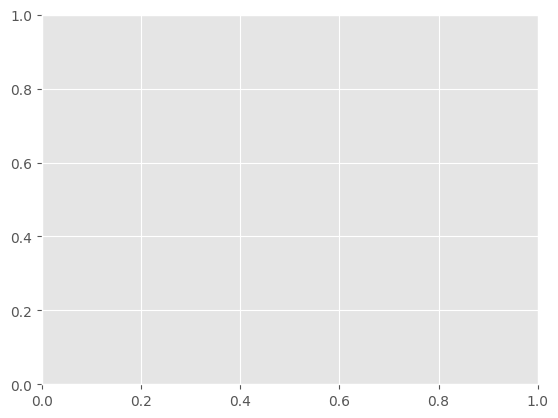

In [8]:
config = EcgConfig()
trainer = ECGClassifierTrainer(config)

train_confusion_matrix, eval_confusion_matrix, epoch_loss = trainer.train()

## Evaluating

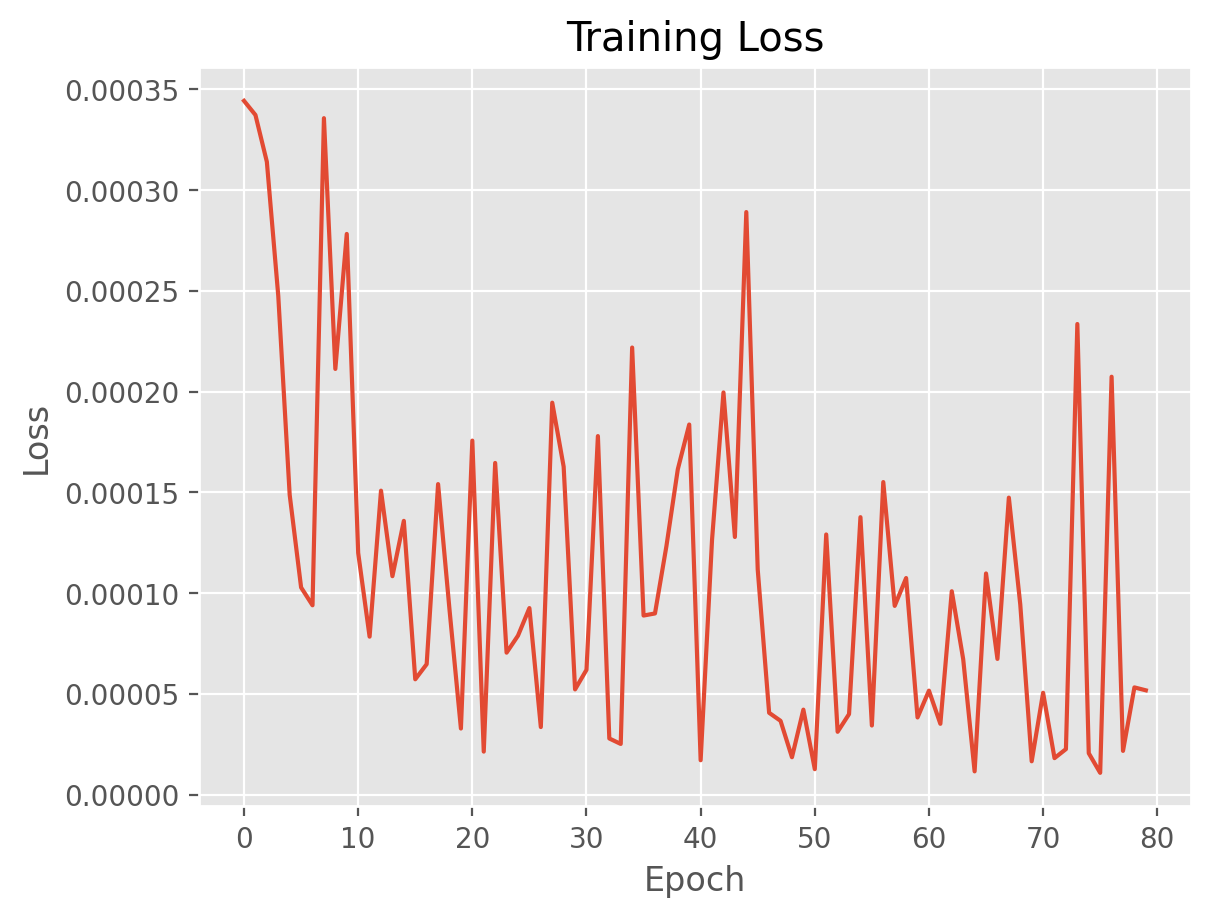

In [9]:
# plot loss
plt.figure(1, dpi=200)
plt.plot(epoch_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
%matplotlib inline
plt.show()

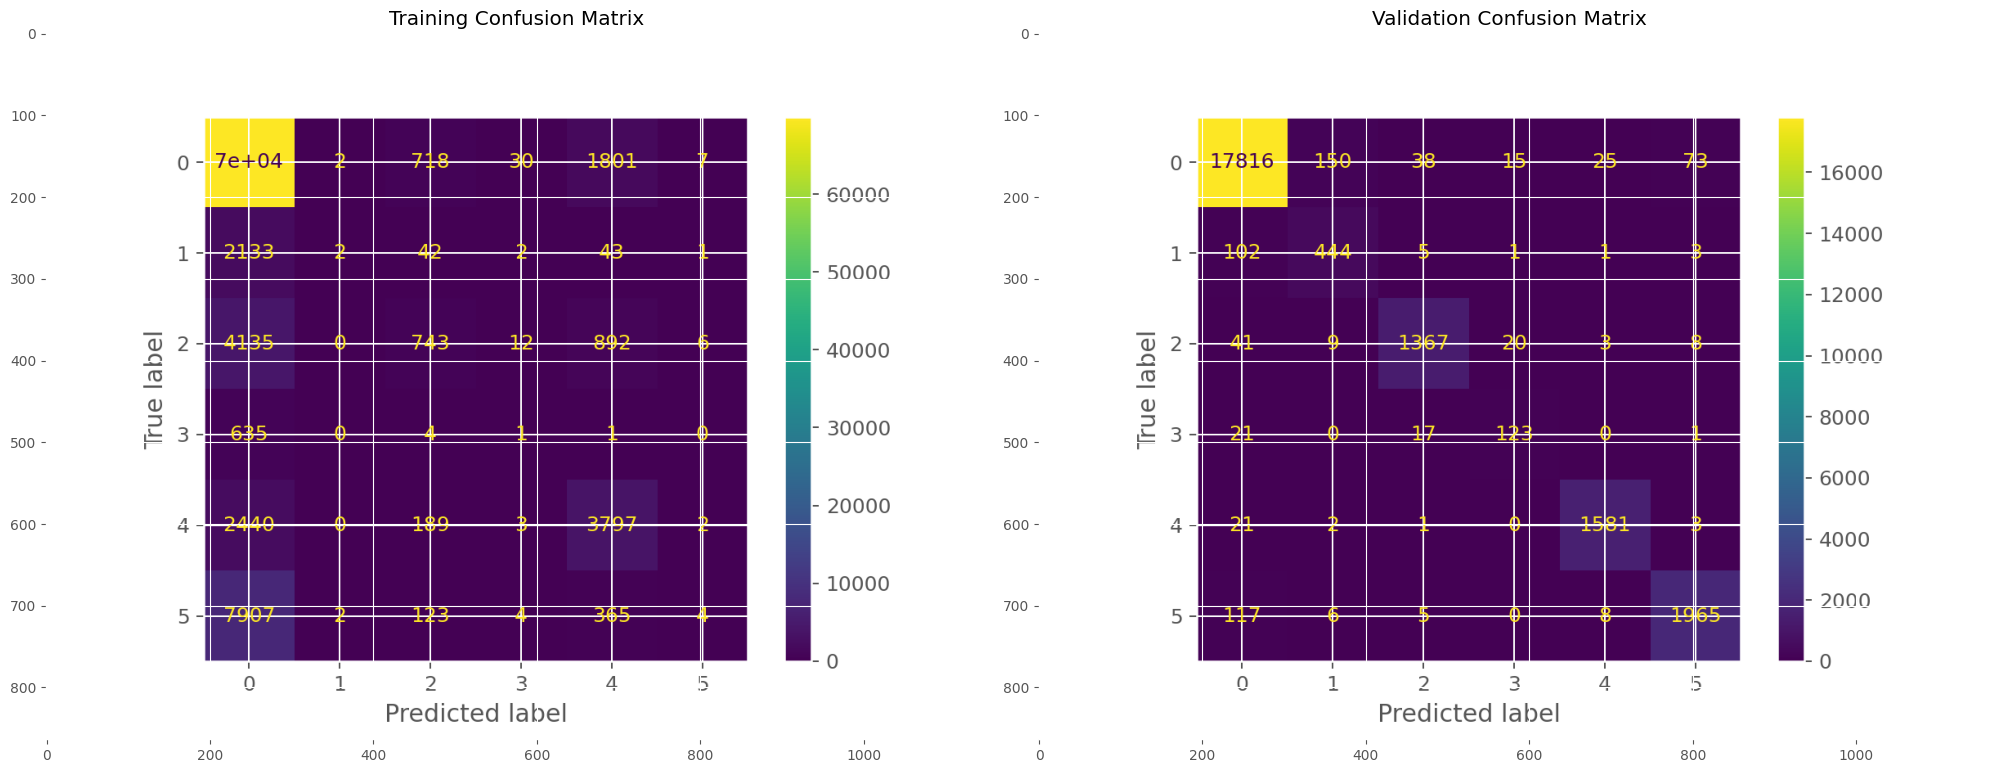

In [10]:
# Confusion matrix
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.imshow(train_confusion_matrix[0])
plt.title("Training Confusion Matrix")


plt.subplot(1, 2, 2)
plt.imshow(eval_confusion_matrix[-1])
plt.title("Validation Confusion Matrix")

plt.tight_layout()
plt.show()


## Save model and load model

In [15]:
import torch
torch.save(model, "..\\model_save\\model.pth")
model_test = torch.load("..\\model_save\\model.pth")
print(model_test)

ECGformer(
  (encoder): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (0): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (queries_projection): Linear(in_features=192, out_features=192, bias=True)
            (values_projection): Linear(in_features=192, out_features=192, bias=True)
            (keys_projection): Linear(in_features=192, out_features=192, bias=True)
            (final_projection): Linear(in_features=192, out_features=192, bias=True)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MLP(
            (0): Linear(in_features=192, out_features=768, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=768, out_features=192, bias=True)
          )
          (2):

In [16]:
import torch.quantization
model(torch.randn(1, config.model.signal_length, 1)).shape

# 使用 Eager Mode Quantization
# 將 torch.nn.Linear 的參數映射到 -127~127 之間
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)
torch.save(quantized_model, "..\\model_save\\model_quantized.pth")
model_test = torch.load("..\\model_save\\model_quantized.pth")

print(model_test)


ECGformer(
  (encoder): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (0): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (queries_projection): DynamicQuantizedLinear(in_features=192, out_features=192, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (values_projection): DynamicQuantizedLinear(in_features=192, out_features=192, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (keys_projection): DynamicQuantizedLinear(in_features=192, out_features=192, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (final_projection): DynamicQuantizedLinear(in_features=192, out_features=192, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)


In [18]:
import einops
loader = get_data_loaders(DatasetConfig())
accuracy = 0
for signal, label in loader[Mode.eval]:
    p = model_test(einops.rearrange(signal, "b c e -> b e c"))
    print(p)
    print(label)
    # print(signal.shape, label.shape)
    print(p.argmax(1))
    print(p.argmax(1) == label)
    accuracy += torch.sum(p.argmax(1) == label)
    print(f"accuracy: {accuracy / config.dataset.batch_size}")
    break



tensor([[ 2.2011e-02,  1.0464e+00, -3.3649e-02, -1.9815e-01, -8.3188e-01,
          2.3233e-01],
        [-1.2998e-02,  9.4587e-01, -1.6984e-02, -2.0715e-01, -7.5514e-01,
          1.8098e-01],
        [ 9.9818e-03,  1.0109e+00, -1.8972e-03, -2.0996e-01, -7.8286e-01,
          2.1403e-01],
        [ 2.6471e-02,  1.0194e+00, -1.6157e-02, -2.2148e-01, -7.9634e-01,
          1.9925e-01],
        [ 1.5044e-02,  9.6797e-01, -2.1770e-02, -2.2239e-01, -7.4351e-01,
          1.8845e-01],
        [ 1.9079e-02,  1.0103e+00, -1.3651e-02, -2.1898e-01, -7.9271e-01,
          2.0982e-01],
        [ 1.7350e-02,  9.2590e-01, -4.1342e-02, -2.2249e-01, -6.9956e-01,
          1.7291e-01],
        [-2.2321e-02,  8.3821e-01, -2.5354e-02, -2.5817e-01, -6.1739e-01,
          1.3800e-01],
        [-6.7835e-03,  9.2191e-01, -5.3305e-03, -2.2324e-01, -6.9800e-01,
          1.6173e-01],
        [ 1.5595e-02,  1.0226e+00, -2.0041e-02, -1.9718e-01, -8.0749e-01,
          2.1584e-01],
        [-1.3074e-02,  8.3997e

## Parameter 提取

In [14]:
for name in model_test.state_dict():
   print(name)

print(quantized_model.state_dict()['encoder.0.0.block.1.queries_projection._packed_params._packed_params'])

positional_encoding
encoder.0.0.block.0.weight
encoder.0.0.block.0.bias
encoder.0.0.block.1.queries_projection.scale
encoder.0.0.block.1.queries_projection.zero_point
encoder.0.0.block.1.queries_projection._packed_params.dtype
encoder.0.0.block.1.queries_projection._packed_params._packed_params
encoder.0.0.block.1.values_projection.scale
encoder.0.0.block.1.values_projection.zero_point
encoder.0.0.block.1.values_projection._packed_params.dtype
encoder.0.0.block.1.values_projection._packed_params._packed_params
encoder.0.0.block.1.keys_projection.scale
encoder.0.0.block.1.keys_projection.zero_point
encoder.0.0.block.1.keys_projection._packed_params.dtype
encoder.0.0.block.1.keys_projection._packed_params._packed_params
encoder.0.0.block.1.final_projection.scale
encoder.0.0.block.1.final_projection.zero_point
encoder.0.0.block.1.final_projection._packed_params.dtype
encoder.0.0.block.1.final_projection._packed_params._packed_params
encoder.0.1.block.0.weight
encoder.0.1.block.0.bias
enco